In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

There's a new jupysql version available (0.10.13), you're running 0.10.12. To upgrade: pip install jupysql --upgrade


In [4]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [5]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-09-17'

In [6]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [7]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [8]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [10]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
from upload.rank_by_name import rankings
# from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['A Bar Song (Tipsy)',
 'I Had Some Help',
 "Ain't No Love In Oklahoma",
 'Miles On It',
 'Lies Lies Lies',
 '...',
 'Maxed Out',
 'A Lot More Free',
 'California Sober',
 'Boys Back Home',
 'Now Or Never']

In [11]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [12]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 25 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
|  29 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |                          0 |
| 162 |        38 | I Had Some Help | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name                 | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:--------------------------|:--------------|:--

|    |   song_id | song_name           | artist_name    | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:--------------------|:---------------|:--------------------|---------------------------:|
| 21 |        30 | Wind Up Missin' You | Tucker Wetmore | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 49 |        62 | Am I Okay?  | Megan Moroney | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name        | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-----------------|:--------------|:--------------------|---------------------------:|
| 30 |        39 | Beautiful As You | Thomas Rhett  | Lead artist         |        

Please enter the song_id or 'New Song'

|     |   song_id | song_name        | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-----------------|:----------------|:--------------------|---------------------------:|
|  63 |        78 | California Sober | Chris Stapleton | Featured artist     |                          0 |
| 173 |        78 | California Sober | Post Malone     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
|  76 |        93 | Boys Back Home | Dylan Scott   | Other main artist   |                          6 |
| 185 |        93 | Boys Back Home | Dylan Marlowe | Lead artist         |                          6 |
Please enter the song_id or 'New Song'



In [10]:
# Notes
# s2a for Pretty Little Poison

In [13]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

45 +
['4x4xU', 'Messed Up As Me', "Darlin'", 'A Lot More Free', 'Now Or Never']


### Add artists on any new songs that aren't in the artist table yet to its CSV

In [14]:
df_artist = pd.read_csv('source_data/artist.csv')

4x4xU: Lainey Wilson(11)
Messed Up As Me: Keith Urban(89)
Darlin': Chase Matthew(18)
A Lot More Free: Max McNown(90)
Now Or Never: Corey Kent(91) feat Lauren Alaina(92)

In [18]:
new_song_artists = [
    'Lainey Wilson'
    , 'Keith Urban'
    , 'Chase Matthew'
    , 'Max McNown'
    , 'Corey Kent'
    , 'Lauren Alaina'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
10,11,Lainey Wilson,1.0,2024-08-23
17,18,Chase Matthew,0.0,2024-08-23
88,89,Keith Urban,0,2024-09-17
89,90,Max McNown,0,2024-09-17
90,91,Corey Kent,0,2024-09-17
91,92,Lauren Alaina,1,2024-09-17


In [16]:
df_artist['artist_id'].max()

88

In [17]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [89, 'Keith Urban', 0, current_date]
                , [90, 'Max McNown', 0, current_date]
                , [91, 'Corey Kent', 0, current_date]
                , [92, 'Lauren Alaina', 1, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [19]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-09-17


### Add all new songs to the song table CSV

In [20]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [21]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[176, '4x4xU', 0, '2024-09-17'],
 [177, 'Messed Up As Me', 0, '2024-09-17'],
 [178, "Darlin'", 0, '2024-09-17'],
 [179, 'A Lot More Free', 0, '2024-09-17'],
 [180, 'Now Or Never', 0, '2024-09-17']]

In [22]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
174,175,Creek Will Rise,9.0,2024-09-16
175,176,4x4xU,0,2024-09-17
176,177,Messed Up As Me,0,2024-09-17
177,178,Darlin',0,2024-09-17
178,179,A Lot More Free,0,2024-09-17
179,180,Now Or Never,0,2024-09-17


4x4xU: Lainey Wilson(11)
Messed Up As Me: Keith Urban(89)
Darlin': Chase Matthew(18)
A Lot More Free: Max McNown(90)
Now Or Never: Corey Kent(91) feat Lauren Alaina(92)

In [22]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    (173, 17)
    , (175, 9)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [23]:
df_song_raw[df_song_raw['song_name'].isin([
    'Pretty Little Poison'
])]

,song_id,song_name,untracked_weeks_on_chart,last_update
7,8,Pretty Little Poison,32.0,2024-8-23


In [23]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
174,175,Creek Will Rise,9.0,2024-09-16
175,176,4x4xU,0,2024-09-17
176,177,Messed Up As Me,0,2024-09-17
177,178,Darlin',0,2024-09-17
178,179,A Lot More Free,0,2024-09-17
179,180,Now Or Never,0,2024-09-17


In [24]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-09-17


#### Add all new songs to the song_to_artist table CSV

In [25]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

4x4xU: Lainey Wilson(11)
Messed Up As Me: Keith Urban(89)
Darlin': Chase Matthew(18)
A Lot More Free: Max McNown(90)
Now Or Never: Corey Kent(91) feat Lauren Alaina(92)

In [26]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [176, 11, '', '']
    , [177, 89, '', '']
    , [178, 18, '', '']
    , [179, 90, '', '']
    , [180, 91, '', '']
    , [180, 92, '', 1]
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['176-Lead artist-', 176, 11, 'Lead artist', '', '', '2024-09-17'],
 ['177-Lead artist-', 177, 89, 'Lead artist', '', '', '2024-09-17'],
 ['178-Lead artist-', 178, 18, 'Lead artist', '', '', '2024-09-17'],
 ['179-Lead artist-', 179, 90, 'Lead artist', '', '', '2024-09-17'],
 ['180-Lead artist-', 180, 91, 'Lead artist', '', '', '2024-09-17'],
 ['180-Featured artist-1', 180, 92, 'Featured artist', '', 1, '2024-09-17']]

In [27]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
222,180-Featured artist-1,180,92,Featured artist,,1,2024-09-17


In [28]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-09-17


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [29]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-09-17-28', '2024-09-17', 28, 176, '2024-09-17'],
 ['2024-09-17-44', '2024-09-17', 44, 177, '2024-09-17'],
 ['2024-09-17-45', '2024-09-17', 45, 178, '2024-09-17'],
 ['2024-09-17-47', '2024-09-17', 47, 179, '2024-09-17'],
 ['2024-09-17-50', '2024-09-17', 50, 180, '2024-09-17']]

In [30]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-09-17


## Push to duckdb

In [31]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [32]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

In [33]:
weeks_lookback = 13 # Arbitrary lookback

with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [34]:
# TODO make this show NA() for lookback windows with zero artist song credits
df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -3:][:25]

weeks_ago,-3,-2,-1,0
artist_name,,,,
Zach Bryan,1,1,1,1
Post Malone,5,4,2,2
Morgan Wallen,3,2,3,3
Beyonce,2,3,4,4
Megan Moroney,4,5,5,5
Jelly Roll,6,6,6,6
Luke Combs,7,7,7,7
Bailey Zimmerman,8,8,8,8
Dylan Scott,10,10,10,9


[Text(0.5, 1.0, 'Number of weeks as main artist'),
 Text(0, 0.5, '# songs x # weeks on chart'),
 Text(0.5, 0, 'Weeks ago')]

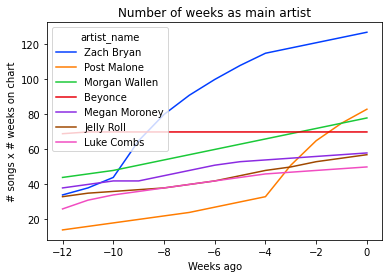

In [37]:
graph = sns.lineplot(
    data = df_artist_ranking.pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = 'recent_weeks_main_artist'
      ).loc[
        df_artist_ranking_over_time[0].keys() # maintain order from rank
      ][:7].fillna(np.inf).T
    , dashes = False
    #, markers = ['.'] * n_cols # TODO define new cols
    , palette = 'bright'
)
graph.set(
    title = 'Number of weeks as main artist'
    , ylabel = '# songs x # weeks on chart'
    , xlabel = 'Weeks ago'
)
# size = scale up plot size, then scale up number of lines

In [38]:
# Current artist rankings
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : len(cols) - 2 ][df_artist_ranking['weeks_ago'] == 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Zach Bryan,0,127,127,127,166,166,166,22,22,22,22,22,22,2.0,2.0,2.0,2,2024-03-26
1,Post Malone,0,78,83,83,78,83,83,19,20,20,19,20,20,1.0,1.0,1.0,1,2024-04-09
2,Morgan Wallen,0,55,78,93,186,209,240,6,8,10,6,8,10,1.0,1.0,1.0,1,2024-03-26
3,Beyonce,0,70,70,70,70,70,70,16,16,16,16,16,16,1.0,1.0,1.0,1,2024-03-26
4,Megan Moroney,0,52,58,58,72,82,82,6,7,7,6,7,7,21.0,21.0,21.0,21,2024-03-26
5,Jelly Roll,0,36,57,85,38,74,103,5,7,9,5,7,9,7.0,7.0,7.0,7,2024-03-26
6,Luke Combs,0,50,50,59,141,141,150,10,10,12,11,11,13,3.0,3.0,3.0,3,2024-03-26
7,Bailey Zimmerman,0,43,43,43,49,49,49,4,4,4,4,4,4,6.0,6.0,6.0,6,2024-03-26
8,Dylan Scott,0,28,43,43,36,57,57,2,3,3,2,3,3,35.0,35.0,35.0,35,2024-03-26
9,Tucker Wetmore,0,42,42,42,42,42,42,3,3,3,3,3,3,11.0,11.0,11.0,11,2024-03-26


In [39]:
%%sql df_weeks_for_artist <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
    , s2a.artist_id
    , art.artist_name
    , s2a.relationship_type
    , art.pct_female
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
LEFT JOIN raw_db.billboard.song_to_artist s2a
    ON br.song_id = s2a.song_id
LEFT JOIN raw_db.billboard.artist art
    ON s2a.artist_id = art.artist_id
ORDER BY 1 ASC

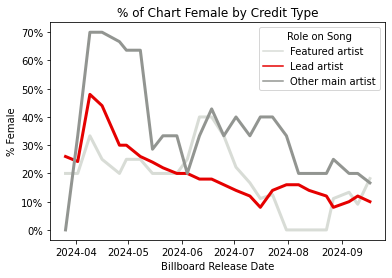

In [40]:
palette = {
    'Lead artist' : 'xkcd:red'
    , 'Other main artist' : 'xkcd:gray'
    , 'Featured artist' : 'xkcd:light gray'
}

graph = sns.lineplot(
    data = df_weeks_for_artist.groupby(
        ['billboard_observation_date', 'relationship_type']
    ).mean()['pct_female'].reset_index()
    , x = 'billboard_observation_date'
    , y = 'pct_female'
    , hue = 'relationship_type'
    , palette = palette
    , linewidth = 3
).set(
    title = '% of Chart Female by Credit Type'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = '% Female'
)

plt.legend(title = 'Role on Song')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.show()

In [41]:
credit_type_to_linestyle = {
    'Lead artist' : 'solid'
    , 'Other main artist' : 'dashed'
    , 'Featured artist' : 'dotted'
}

In [42]:
# TODO enrich with n_songs from above
df_weeks_for_artist[
    df_weeks_for_artist['billboard_observation_date'] == billboard_observation_date
].groupby('artist_name').count().iloc[:,1].loc[
    lambda x: x > 1
].sort_values(ascending = False)

artist_name
Post Malone        8
Jelly Roll         4
Morgan Wallen      4
Zach Bryan         3
Chase Matthew      2
Chris Stapleton    2
Dylan Scott        2
Koe Wetzel         2
Lainey Wilson      2
Luke Combs         2
Riley Green        2
Zach Top           2
Name: song_id, dtype: int64

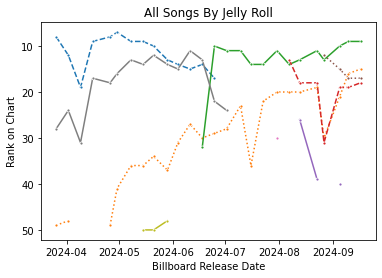

In [55]:
# For now, manual artist name selection
# TODO: Create charts for every artist on this week's chart at once
artist_name = 'Jelly Roll' # TODO: use artist ID, but label with artist_name

df_weeks_this_artist = df_weeks_for_artist.query(
    f"artist_name == '{artist_name}'"
)

sns.color_palette('Paired') # TOFIX
for _, row in df_weeks_this_artist.pivot( # TODO no pivot to support legend in char 'song_name'
    index = 'song_id'
    , columns = 'billboard_observation_date' #TODO: weeks ago
    , values = 'billboard_rank'
).fillna(
    np.inf # suppresses only if a different song is on the chart that week
).iterrows():
    graph = sns.lineplot(
        data = row
        , linestyle = credit_type_to_linestyle[
            df_weeks_this_artist[
                df_weeks_this_artist['song_id'] == row.name
            ].groupby('relationship_type').count().iloc[0].name
        ]
        , marker = '.'
    )
    
graph.set(
    title = f'All Songs By {artist_name}'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = 'Rank on Chart'
)
graph.axes.invert_yaxis()
# Force 0-50 axis and -25 to 0 on the weeks back

In [56]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-17                 │    50 │
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│     ·                      │     · │
│     ·                      │     · │
│     ·                      │     · │
│ 2024-05-29                 │    50 │
│ 2024-05-21                 │    50 │
│ 2024-05-15                 │    50 │
│ 2024-05-08                 │    50 │
│ 2024-04-30                 │    50 │
│ 2024-04-26                 │    50 │
│ 2024-04-16                 │    50 │
│ 2024-04-09                 │    50 │
│ 2024-04-02             

In [58]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2024-09-10'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬────────────────────────────────────────┬────────────────┐
│ song_id │               song_name                │ ranking_before │
│  int32  │                varchar                 │     int32      │
├─────────┼────────────────────────────────────────┼────────────────┤
│      29 │ Young Love & Saturday Nights           │             26 │
│      44 │ She's Somebody's Daughter (Reimagined) │             34 │
│      42 │ Hang Tight Honey                       │             36 │
│      82 │ Yours                                  │             47 │
│      80 │ Finer Things                           │             48 │
│      63 │ Out Of Oklahoma                        │             50 │
└─────────┴────────────────────────────────────────┴────────────────┘



In [59]:
# TODO consider adding a measurement start date column
    # for Friday of each week based on observation date

In [60]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

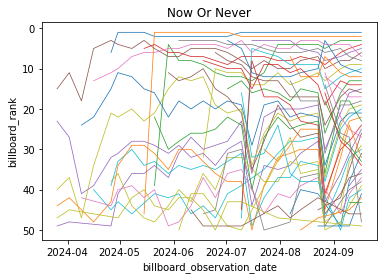

In [61]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(np.inf)
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        # , marker = '.' # TODO: add back with bigger chart
        , dashes = False
        , linewidth = 0.75
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    ).set_title(this_song.reset_index()['song_name'][0])
    
graph.axes.invert_yaxis()
# TODO: verticalize x-axis labels
# TODO: Make this about 4x bigger

In [112]:
# TODO maybe: Each song on its own tile, rather than overlapped